In [1]:
import numpy as np
import pandas as pd
import glob, os
from scipy.stats import norm, gamma, stats, skew
import statistics
import matplotlib.pyplot as plt
import matplotlib.style as style

--- **Data Aggregation and Cleaning were here** ---

Initially this script included lines meant for data aggregation and cleaning. As the process is going to be the same for all upcoming scripts, these lines are deleted. However, they can be found in the first script related to Safety and Cycle Stock calculation.

--- **Gamma Distribution Calculation script starts here** ---

In case of Gamma Distribution Simulation we will not use the data for a specific product, but for the whole product range shipped from Supplier to Retailer.

Data sample is displayed below.

In [20]:
print(dfPivot.sample(5))

Line_ID Movement_Week Movement_Date       EAN_Code Base_Unit_Code  Stock  Transit  Shipped  OOS  Demand
34               cw06    2021-02-11  4000000000001     1000000001    408        0      408    0     408
5840             cw36    2020-09-06  4000000000002     1000000002   3273     1728      648    0     648
763              cw03    2021-01-22  4000000000003     1000000003   4806        0     2832   24    2856
2164             cw51    2020-12-14  4000000000004     1000000004   5222        0       54    0      54
5914             cw36    2020-09-04  4000000000005     1000000005  27964        0      864    0     864


This line is kept in order to quickly switch from full products' range analysis to one product's only. The mentioned product is one of supplier's bestsellers.

In [21]:
# dfPivot = dfPivot[dfPivot['Base_Unit_Code'] == '1000000006']

We choose calendar day as a period. 

In [22]:
dfGamma = dfPivot.groupby('Movement_Date',as_index=False)[['Stock','Shipped','OOS','Demand']].sum()
dfGamma = dfGamma[['Movement_Date','Demand']].set_index('Movement_Date')
dfGamma.index.name = None

Aggregated quantities can be observed in the following chart.

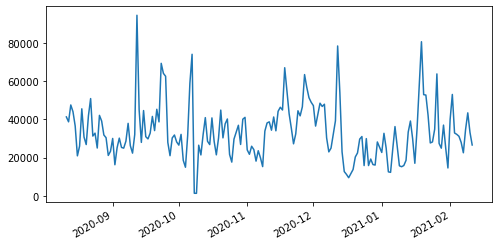

In [23]:
dfGamma.plot(figsize=(8,4),legend=None)
plt.show()

On the plot we can see extremely low value around early October'20. In order to prevent rough outliers from affecting our analysis, we will additionally check the minimum values.

In [24]:
print(dfGamma.sort_values(by='Demand').head(7))

Line_ID     Demand
2020-10-09    1280
2020-10-08    1297
2020-12-17    9432
2020-12-16   11181
2020-12-18   11619
2021-01-05   12249
2021-01-04   12508


Above we see that the demand was extremely low within two days in October'20. It may have been the day of warehouse partial closure or the day the inventory checks were carried out. For that reason I decide to ignore the actual minimum in the datased and choose the third value in a row - 9432.

However, the new adequate minimum may appear, that's why I will set a certain threshold for this value and next value above this border will be used.

In [25]:
dfGamma = dfGamma[dfGamma['Demand'] > 4000]

Now we will find and display some values that would be used in further analytics and simulation.

*Sigma (std)* is standard deviation value for products' demand.

In [26]:
std = int(np.std(dfGamma['Demand'],ddof=1)) # standard deviation or std

Below we find and display the *mu (mean)*, *median*, *mode*, *minimum* and *maximum* for demand data.

In [27]:
mu = int(dfGamma['Demand'].mean())       # mu corresponds to the mean value
median = int(dfGamma['Demand'].median())
mode = statistics.mode(dfGamma['Demand'])
d_min = int(dfGamma['Demand'].min())
d_max = int(dfGamma['Demand'].max())

In [28]:
print('\n','std:',std,'\n','mu:',mu,'\n','median:',median,
      '\n','mode:',mode,'\n','\n','minimum:',d_min,'\n','maximum:',d_max)


 std: 14188 
 mu: 33632 
 median: 31108 
 mode: 41236 
 
 minimum: 9432 
 maximum: 94405


Now we will get a number of available data points. As we receive new data daily, this value will increase over time.

For that reason we calculate a number of bins as 1/3 of all data points available. It's likely to provide the more precise overview of the available data.

In [29]:
data_points = len(dfGamma.index)
bins = int(data_points*0.33)

print("All data points:",data_points)
print("Number of bins:",bins)

All data points: 179
Number of bins: 59


Now we will display the distribution on a histogram.

In [30]:
hist_range = (dfGamma.Demand.min()*0.8,dfGamma.Demand.max()*1.2)
y_actuals, edges = np.histogram(dfGamma, bins=bins, density=True, range=hist_range)
y_actuals = y_actuals/sum(y_actuals)

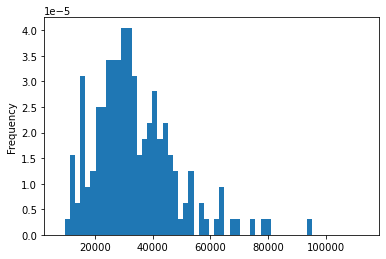

In [31]:
dfGamma.plot(kind='hist',density=True,bins=bins,range=hist_range,legend=None)
plt.show()

Below we calculate skewness.

In [32]:
skewness = skew(dfGamma.Demand,bias=False)
# skewness = dfGamma.Demand.skew() # another method for skewness calculation

print('Actual skewness:',np.round(skewness,decimals=3))

Actual skewness: 1.178


As our result is greather than 1, it means that we have the highly right-skewed distribution. In this case the skew - or tail - is located on the right.

Now we're going to calculate the PDF (probability density function) of a gamma distribution and its **fitted** version that is likely to display the distribution in a more precise way.

In [33]:
shape = mu**2/std**2 # k
scale = std**2/mu      # theta

In [34]:
x_min = gamma.ppf(0.01, shape, scale=scale)
x_max = gamma.ppf(0.99, shape, scale=scale)

In [35]:
x = np.linspace(x_min, x_max, 200)
y = gamma.pdf(x, shape, scale=scale)

In order to fit the density function we would use a modified value of the mean.

In [36]:
mu_p = mu - d_min # mu
shape_p = mu_p**2/std**2 # k
scale_p = std**2/mu_p # theta

In [37]:
x_min = gamma.ppf(0.01, shape_p, loc=d_min, scale=scale_p)
x_max = gamma.ppf(0.99, shape_p, loc=d_min, scale=scale_p)

In [38]:
x1 = np.linspace(x_min,x_max, 200)
y1 = gamma.pdf(x, shape_p, loc=d_min, scale=scale_p)

Now we will see the difference between 2 functions: standard and fitted (with offset).

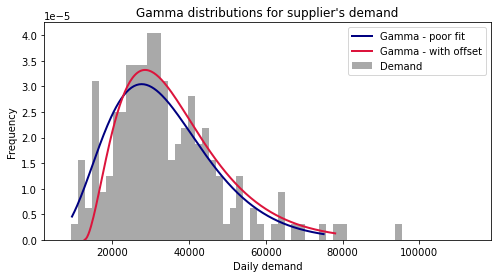

In [39]:
fig, ax = plt.subplots()

dfGamma.plot(figsize=(8,4),ax=ax,kind='hist',density=True,bins=bins,range=hist_range,color='darkgrey')
ax.plot(x,y,label='Gamma - poor fit',color='navy',linewidth=2)
ax.plot(x1,y1,label='Gamma - with offset',color='crimson',linewidth=2)

ax.set_title("Gamma distributions for supplier's demand")
ax.set_xlabel('Daily demand')

plt.legend()
plt.show()

To make sure that our distribution is rather Gamma than Normal we need to observe its skewness values: for both actual and fitted versions.

In [40]:
skew_actual = skew(dfGamma.Demand,bias=False)
skew_gamma = 2*std/mu
skew_gamma_p = 2*std/(mu-d_min)

In [41]:
print('\n','Actual:',np.round(skew_actual,decimals=3),
      '\n','Gamma:',np.round(skew_gamma,decimals=3),
      '\n','Gamma fitted:',np.round(skew_gamma_p,decimals=3))


 Actual: 1.178 
 Gamma: 0.844 
 Gamma fitted: 1.173


Gamma fitted value is slightly closer to gamma value than actual one. It adds some additional precision to distribution evaluation.

With all the data we've found, now we'll calculate the recommended up-to and safety stock levels. We're working with a full products' range demand. This type of calculation may be useful for general tracking of total stock. 

If it exceeds the up-to level, it may become a sign to explore the reasons.

In [42]:
alpha = 0.95 # target cycle service level
L = 4        # lead time
R = 7        # review period

In [43]:
x_min = (R+L)*d_min                         # minimum demand during replenishment cycle
x_mu = (R+L)*mu                             # mean demand during replenishment cycle
x_mu_p = x_mu - x_min                       # offset value of the mean
x_std = np.sqrt(R+L)*std                    # offset standard deviation 
x_shape_p = x_mu_p**2/x_std**2              # offset shape of distribution
x_scale_p = x_std**2/x_mu_p                 # offset scale of distribution

In [44]:
S = round(gamma.ppf(alpha,x_shape_p,scale=x_scale_p),0) + x_min # up-to level
Ss = S - x_mu                                                   # safety stock

In [45]:
print('Up-to level:',S)
print('Safety stock:',Ss)

Up-to level: 451786.0
Safety stock: 81834.0
